In [ ]:
# api token upload
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shifamehreen","key":"8b94ce850d6d49c566ad1e21d062cd71"}'}

In [ ]:
# load dataset form kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


In [ ]:
df = pd.read_csv("/content/full_df.csv")
df.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2554,3943,54,Male,3943_left.jpg,3943_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3943_right.jpg
2637,4043,64,Male,4043_left.jpg,4043_right.jpg,severe nonproliferative retinopathy,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4043_right.jpg
2894,4331,75,Male,4331_left.jpg,4331_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4331_right.jpg
3555,419,57,Male,419_left.jpg,419_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",419_left.jpg
5479,3173,46,Male,3173_left.jpg,3173_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3173_left.jpg


In [ ]:
df.shape

(6392, 19)

In [ ]:
def has_glaucoma(text):
  if "glaucoma" in text:
    return 1
  else:
    return 0

In [ ]:
df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

In [ ]:
left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
left_glaucoma[:15]

array(['95_left.jpg', '153_left.jpg', '167_left.jpg', '178_left.jpg',
       '247_left.jpg', '365_left.jpg', '583_left.jpg', '625_left.jpg',
       '746_left.jpg', '931_left.jpg', '1209_left.jpg', '1210_left.jpg',
       '1211_left.jpg', '1212_left.jpg', '1213_left.jpg'], dtype=object)

In [ ]:
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
right_glaucoma[:15]

array(['43_right.jpg', '167_right.jpg', '238_right.jpg', '247_right.jpg',
       '365_right.jpg', '583_right.jpg', '746_right.jpg', '931_right.jpg',
       '1209_right.jpg', '1210_right.jpg', '1211_right.jpg',
       '1212_right.jpg', '1213_right.jpg', '1214_right.jpg',
       '1215_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_glaucoma)))
print("Number of images in right cataract: {}".format(len(right_glaucoma)))

Number of images in left cataract: 332
Number of images in right cataract: 284


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(glaucoma),len(normal))

616 500


In [ ]:
from keras_preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset


In [ ]:
dataset = create_dataset(glaucoma,1)

100%|██████████| 616/616 [00:03<00:00, 195.71it/s]


In [ ]:
len(dataset)

613

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 198.76it/s]


In [ ]:
len(dataset)

1113

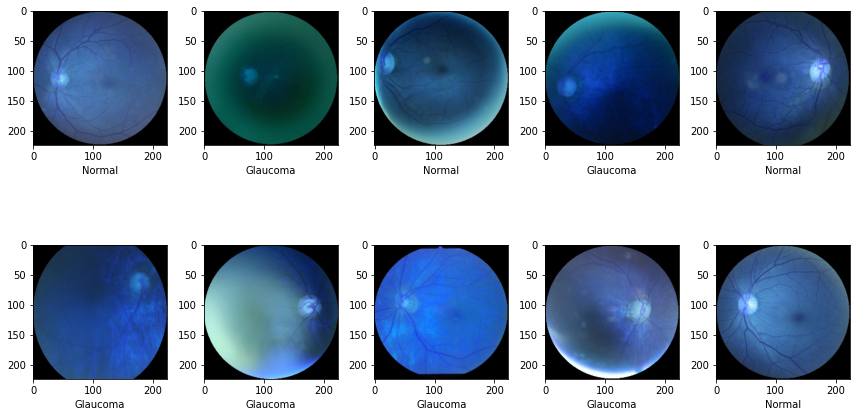

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

MODEL

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
 5/28 [====>.........................] - ETA: 7:12 - loss: 4.8320 - accuracy: 0.5688

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")


In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);



In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()






In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()